# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad, config
import jaxquantum as jqt
import jaxquantum.devices as jqtd
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

# 1 - Devices

## Estimating Ec (because we didn't have it)

In [6]:
Ej1 = 8.2
Ej2 = 23
Ejsum = Ej1 + Ej2
phi_ext = 0.5
phi_ext = 2 * jnp.pi * phi_ext
gamma = Ej2 / Ej1
d = (gamma - 1) / (gamma + 1)
external_flux_factor = jnp.abs(
    jnp.sqrt(jnp.cos(phi_ext / 2) ** 2 + d**2 * jnp.sin(phi_ext / 2) ** 2)
)
Ej_eff = Ejsum * external_flux_factor

f01 = 3.78 

f01**2 / (8 * Ej_eff)

Array(0.12067905, dtype=float64, weak_type=True)

## Tunable Transmon

In [8]:
Ec_q = 0.125
Ej1 = 8.2 
Ej2 = 23

@jit
def gen_symmetric_tunable_transmon(phi_ext):
    qubit = jqtd.TunableTransmon.create(
        23, # final Hilbert space dimension, after diagonalization and truncation
        {"Ec": Ec_q, "Ej1": Ej1, "Ej2": Ej2, "phi_ext": phi_ext},
        basis=jqtd.BasisTypes.charge,
        hamiltonian=jqtd.HamiltonianTypes.full,
        N_pre_diag=23, # pre-diagonalization Hilbert space dimension
    )
    return qubit

@jit
def get_energies(qubit):
    Es = qubit.eig_systems["vals"]
    f_10 = Es[1]-Es[0]
    f_21 = Es[2]-Es[1]
    return f_10, f_21

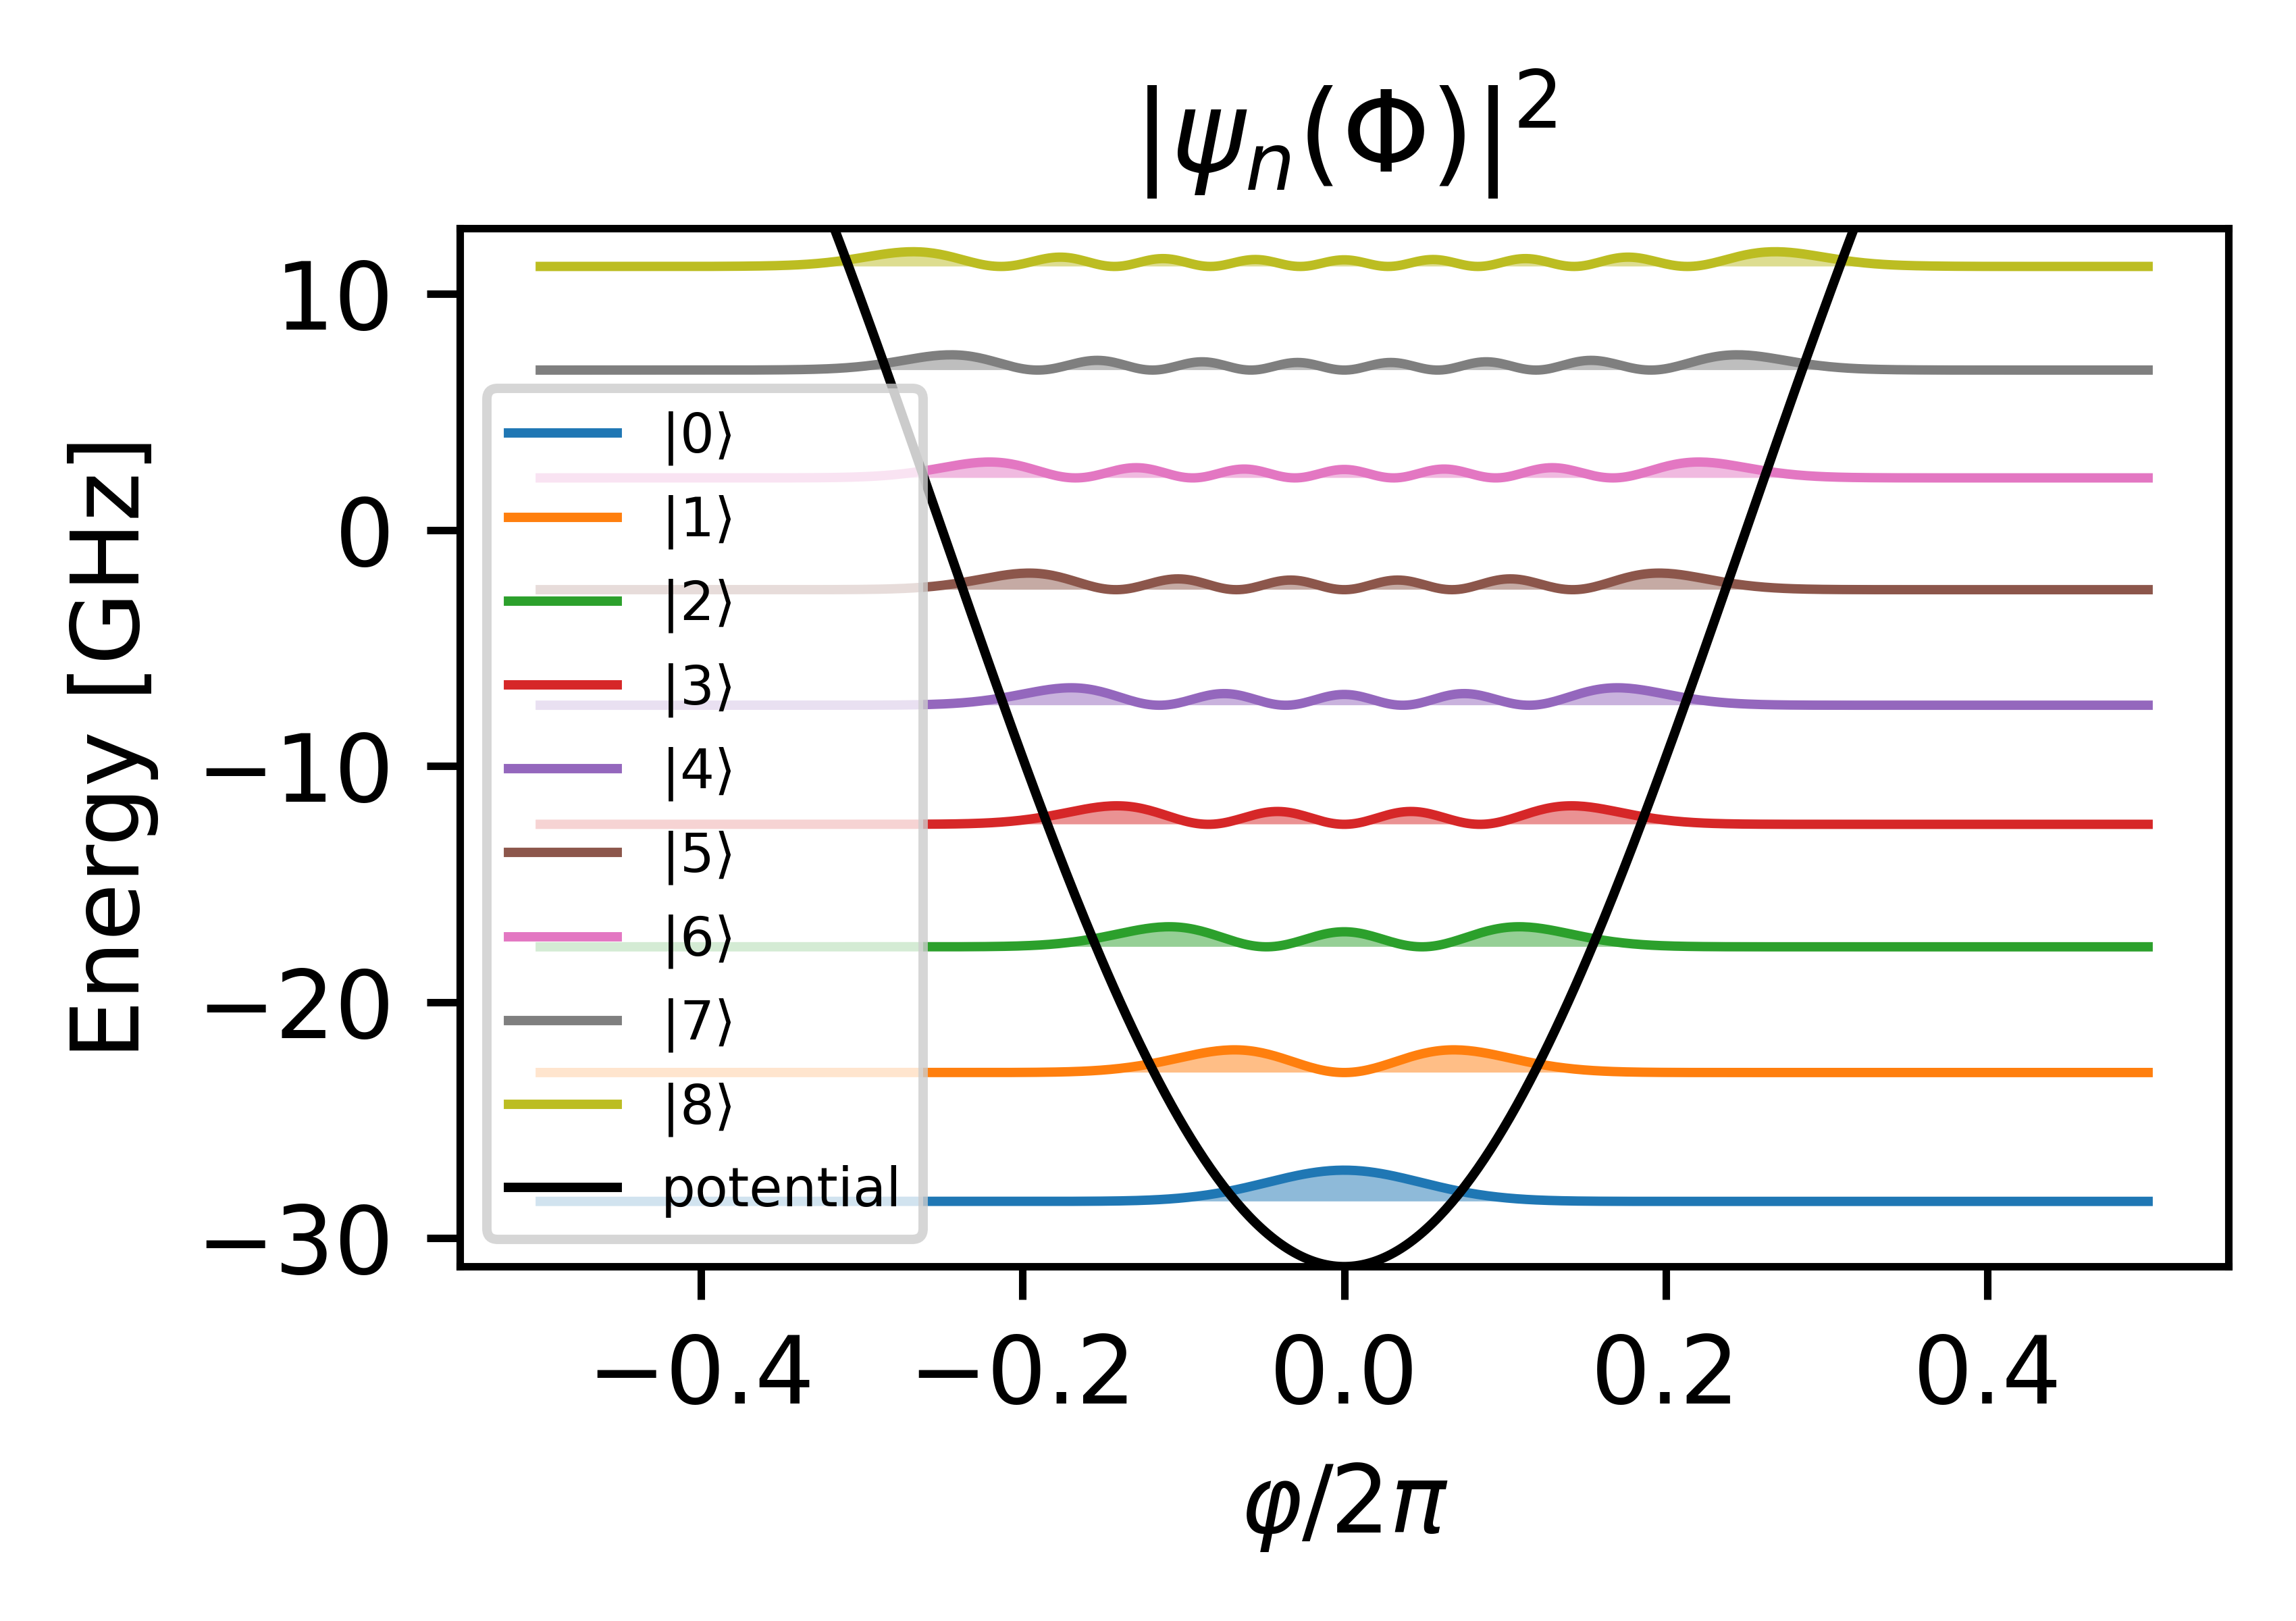

In [9]:
qubit = gen_symmetric_tunable_transmon(0.0)
phi_vals = jnp.linspace(-0.5,0.5,500)
axs = qubit.plot_wavefunctions(phi_vals,  max_n = 9)

In [10]:
phi_exts = jnp.linspace(-1,1,500)

f_10s = []
f_21s = []

for phi_ext in tqdm(phi_exts): # this can be vmapped for a speed up, if there's enough memory
    qubit = gen_symmetric_tunable_transmon(phi_ext) 
    f_10, f_21 = get_energies(qubit)
    f_10s.append(f_10)
    f_21s.append(f_21)

f_10s = jnp.array(f_10s)
f_21s = jnp.array(f_21s)

100%|██████████| 500/500 [00:00<00:00, 2520.65it/s]


Text(0, 0.5, 'Transition Frequency [GHz]')

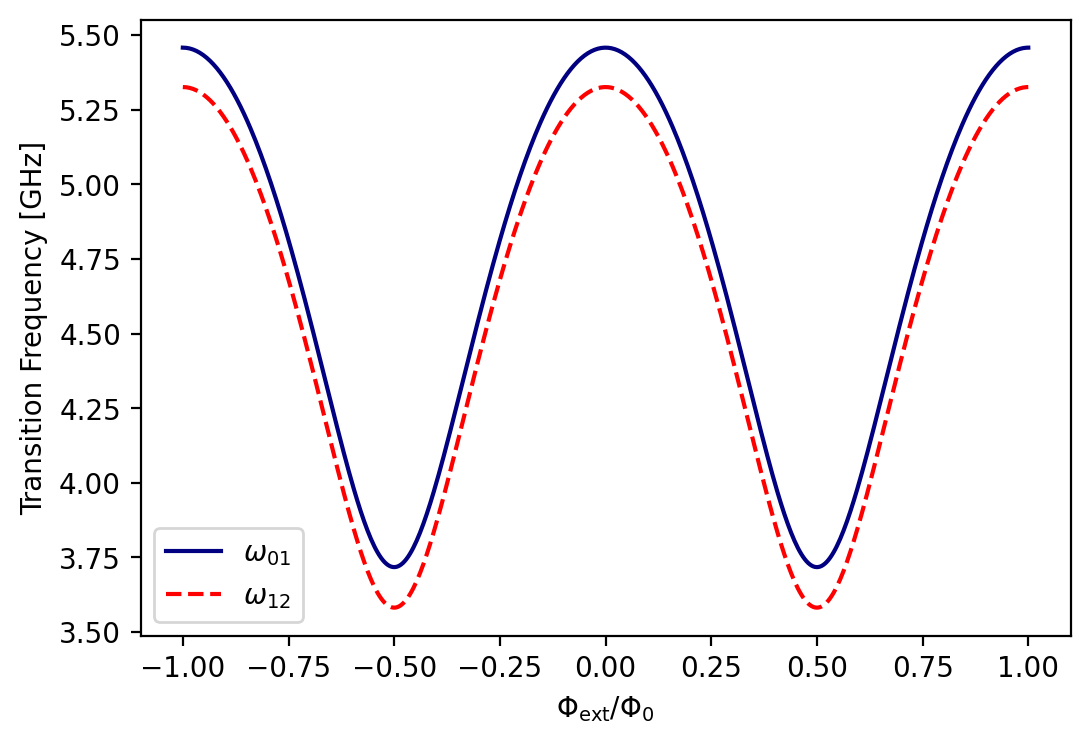

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=200)
ax.plot(phi_exts, f_10s, label=r"$\omega_{01}$", color="navy")
ax.plot(phi_exts, f_21s, label=r"$\omega_{12}$", color="red", linestyle="--")
ax.set_xlabel(r"$\Phi_{\rm ext}/\Phi_0$")
ax.legend()
ax.set_ylabel(r"Transition Frequency [GHz]")

## TLS

In [10]:
tls = jqtd.IdealQubit.create(
        2,
        {"ω": 5.0}, # GHz
        basis=jqtd.BasisTypes.fock,
        hamiltonian=jqtd.HamiltonianTypes.full,
        N_pre_diag=2,
    )

# 2 - Tunable Transmon - Tunable Transmon - TLS (Ideal Qubit)

First, let's set up the modes, which consist of a tunable transmon coupled to a tunable transmon coupled to a TLS.

In [3]:
Ecq = 0.125
Ej1q = 8.2 
Ej2q = 23

phi_ext_1 = 0.0
phi_ext_2 = 0.0

qubit_1 = jqtd.TunableTransmon.create(
    3, # final Hilbert space dimension, after diagonalization and truncation
    {"Ec": Ecq, "Ej1": Ej1q, "Ej2": Ej2q, "phi_ext": phi_ext_1},
    basis=jqtd.BasisTypes.charge,
    hamiltonian=jqtd.HamiltonianTypes.full,
    N_pre_diag=23, # pre-diagonalization Hilbert space dimension
    label=0,
)

qubit_2 = jqtd.TunableTransmon.create(
    3, # final Hilbert space dimension, after diagonalization and truncation
    {"Ec": Ecq, "Ej1": Ej1q, "Ej2": Ej2q, "phi_ext": phi_ext_2},
    basis=jqtd.BasisTypes.charge,
    hamiltonian=jqtd.HamiltonianTypes.full,
    N_pre_diag=23, # pre-diagonalization Hilbert space dimension
    label=1,
)

tls = jqtd.IdealQubit.create(
        2,
        {"ω": 5.0, "Δ": 0.0}, # GHz
        basis=jqtd.BasisTypes.fock,
        hamiltonian=jqtd.HamiltonianTypes.full,
        N_pre_diag=2,
    )

In [4]:
λ = 0.0 # NOTE: dimensionless coupling strength to between qubit2 and the TLS, for now this is set to zero
g = 5e-3 # GHz # qubit1 - qubit2 coupling strength

devices = [qubit_1, qubit_2, tls]
q1_indx = 0
q2_indx = 1
t_indx = 2

Ns = [device.N for device in devices]


n1 = jqtd.promote(qubit_1.ops["n"], q1_indx, Ns)
n2 = jqtd.promote(qubit_2.ops["n"], q2_indx, Ns)
σz = jqtd.promote(tls.ops["sigmaz"], t_indx, Ns)

couplings = [] 

# coupling between qubit 2 and tls 
couplings.append(8*qubit_2.params["Ec"]*λ * n1 @ σz)


J = g / (qubit_1.n_zpf() * qubit_2.n_zpf())

# charge coupling between qubit 1 and qubit 2
couplings.append(J * n1 @ n2)


system = jqtd.System.create(devices, couplings=couplings)
system.params["λ"] = λ

In [5]:
Es, kets = system.calculate_eig()
H_full = system.get_H()

N1 = jqtd.promote(jqt.create(Ns[0]) @ jqt.destroy(Ns[0]), q1_indx, Ns)
N2 = jqtd.promote(jqt.create(Ns[1]) @ jqt.destroy(Ns[1]), q2_indx, Ns)

### Exchange 01-10

In [6]:
f_1 = Es[1,0,0] - Es[0,0,0]
f_2 = Es[0,1,0] - Es[0,0,0]
f_avg = (f_1 + f_2) / 2

H_full_rot = H_full - f_avg * (N1 + N2)

phi_plus = (kets[1,0,0] + kets[0,1,0]).unit()
phi_minus = (kets[1,0,0] - kets[0,1,0]).unit()

p_plus = phi_plus.to_dm()
p_minus = phi_minus.to_dm()

In [7]:
ts = jnp.linspace(0, 200*2*jnp.pi, 101)  # time in ns
initial_state = phi_plus  # qubit 1 in |1>, qubit 2 in |0>, TLS in |0>
solver_options = jqt.SolverOptions.create(max_steps=1_000_000)
states = jqt.sesolve(H_full_rot, initial_state, ts, solver_options=solver_options)

100% |██████████| [00:46<00:00,  2.17%/s]


Text(0, 0.5, 'Expectation Value')

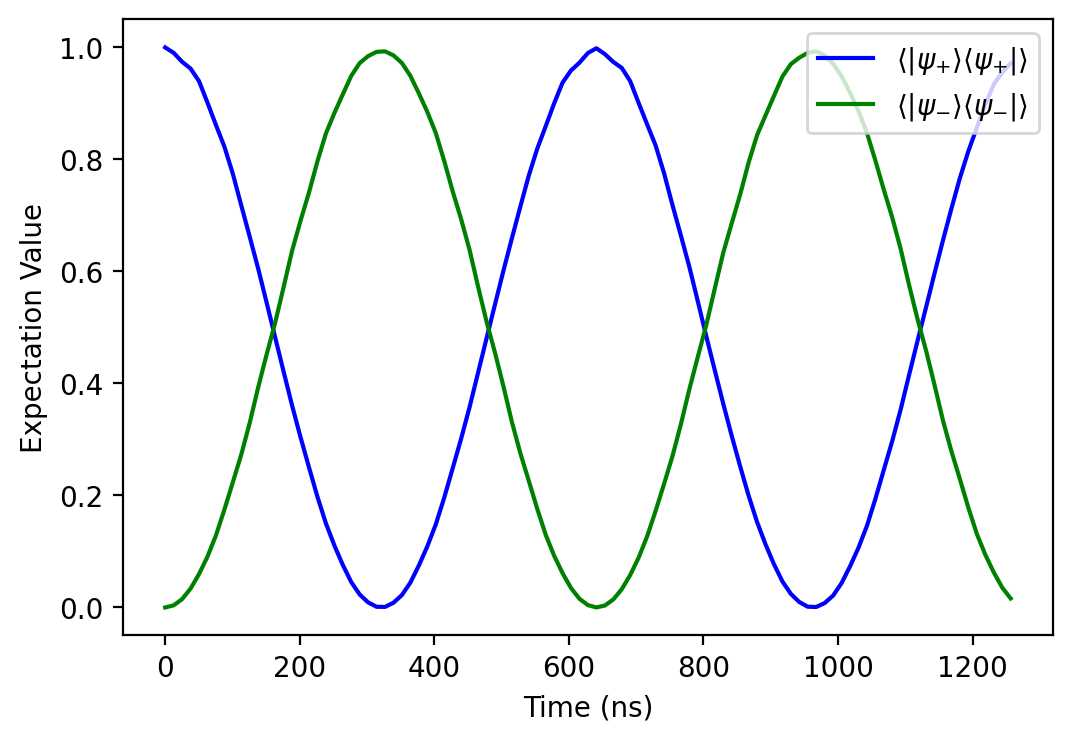

In [8]:
p_plus_t = jnp.real(jqt.overlap(states, p_plus))
p_minus_t = jnp.real(jqt.overlap(states, p_minus))

fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=200)
ax.plot(ts, p_plus_t, label=r"$\langle |\psi_\plus\rangle \langle \psi_\plus| \rangle$", color="blue")
ax.plot(ts, p_minus_t, label=r"$\langle |\psi_\minus\rangle \langle \psi_\minus| \rangle$", color="green")

ax.legend(loc="upper right")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Expectation Value")

### Exchange 11-02

In [9]:
f_1 = Es[1,1,0] - Es[0,0,0]
f_2 = Es[0,2,0] - Es[0,0,0]
f_avg = (f_1 + f_2) / 2

H_full_rot = H_full - f_avg * (N1 + N2)

phi_plus = (kets[1,1,0] + kets[0,2,0]).unit()
phi_minus = (kets[1,1,0] - kets[0,2,0]).unit()

p_plus = phi_plus.to_dm()
p_minus = phi_minus.to_dm()

In [12]:
ts = jnp.linspace(0, 20*2*jnp.pi, 101)  # time in ns
initial_state = phi_plus  # qubit 1 in |1>, qubit 2 in |0>, TLS in |0>
solver_options = jqt.SolverOptions.create(max_steps=1_000_000)
states = jqt.sesolve(H_full_rot, initial_state, ts, solver_options=solver_options)

100% |██████████| [00:02<00:00, 35.94%/s]


Text(0, 0.5, 'Expectation Value')

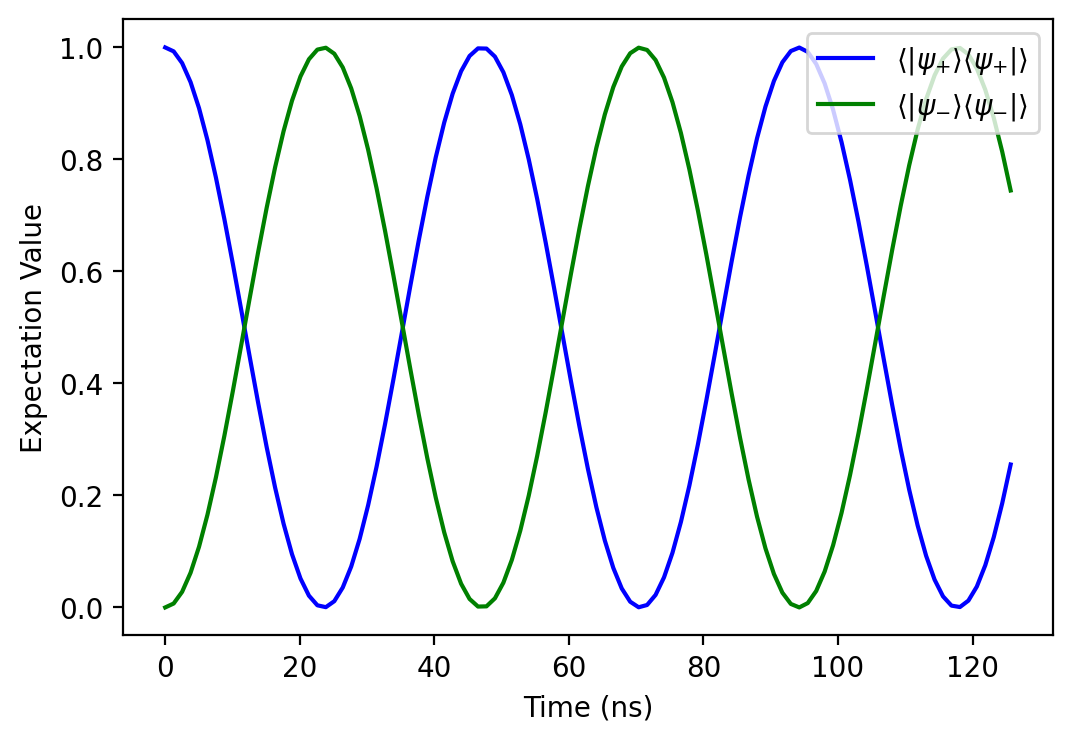

In [13]:
p_plus_t = jnp.real(jqt.overlap(states, p_plus))
p_minus_t = jnp.real(jqt.overlap(states, p_minus))

fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=200)
ax.plot(ts, p_plus_t, label=r"$\langle |\psi_\plus\rangle \langle \psi_\plus| \rangle$", color="blue")
ax.plot(ts, p_minus_t, label=r"$\langle |\psi_\minus\rangle \langle \psi_\minus| \rangle$", color="green")

ax.legend(loc="upper right")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Expectation Value")